<a href="https://colab.research.google.com/github/orlowan1/image_classification/blob/main/GeneralizedSubsetClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Model to Production:
A gneralized classifier provides opportunity to insert experiments, reproduce results and repeat with different datasets. 

This notebook will outline procedure for creaing a resnet34 based image classification model for classifying objects that are a subset of a particular base type. 

Example of objects that are a subset of a particular base type could be [black cow, white cow, purple cow] or [sail boat, power boat, sunk boat] or [oak tree, pine tree, willow tree], etc... 

The premise is that there is a 'base' type and its 'sub' types are identifiable:
>- Basic: {concrete noun: [attributive adjectives]}
>- Advanced: {abstract noun: [attributive adjectives]}
---
1. Overhead.
1. Definitions.
1. Use `duckdduckgo_search` to obtain links to representative images.
1. Download a set of images per sub type into directories representatively named. 
1. Test for and drop corrupt image files.
1. Use `jmd_imagescraper.imagecleaner` to inspect image files.
1. Create DataLoaders and inspect image sample with labels.
1. Create Learner and train model.
1. Intrepret performance, further clean data.
1. Rebuild Dataloaders, create Learner, train model, intrepret performance.
1. Export Model.
1. Import Model.
1. Test on image data




### Overhead

In [1]:
import random
from pathlib import Path

from fastcore.all import *
from fastdownload import *
from fastai.vision.all import *
from fastai.vision.widgets import *


In [2]:
# Use duckduckgo_search for image scraping
!pip install -Uqq duckduckgo_search
from duckduckgo_search import ddg_images

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
# Since working on CoLab we need to mount My Drive so that we can export the 
# model from this notebook's filesystem to MyDrive where it will be available 
# for other use. 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# make nbdev dev available if we need doc()
!pip install -Uqq nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00


### Definitions



In [ ]:
# set our definitions
base = 'cow'
classifications = ['white', 'black', 'purple']

#base = 'boat'
#classifications = ['power', 'sail', 'sunk']

#base = 'tree'
#classifications = ['oak', 'pine', 'willow']

#base = 'emotion'
#classifications = ['good', 'bad']

path = Path(base)
print("Path: ", path)

model_export_path = "/content/drive/MyDrive/"
model_export_name = f"mdlexp_{base}.pkl"
print('model to export as:', model_export_name)
!ls -la { model_export_path } 

### Use ddg_search to obtain links to representative images.


In [6]:
# dedine a search function
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Download a set of images per sub type into directories representatively named. 

In [7]:
# clean out any old files
if path.exists():
  shutil.rmtree(path)

# reset path
if not path.exists():
    path.mkdir()

# search and download image data
if path.exists():
  for x in classifications:
    dest = (path/x)
    dest.mkdir(exist_ok=True)
    results = search_images(f'{x} {base}', max_images=200)
    print(f'Found {len(results)} to download')
    download_images(dest, urls=results)

Searching for 'white cow'
Found 192 to download
Searching for 'black cow'
Found 196 to download
Searching for 'purple cow'
Found 175 to download


### Test for and drop corrupt image files.

In [8]:
# unlink any files that are not open'able
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)
print(f'{len(fns)} files downloaded; {len(get_image_files(path))} are useable')

539 files downloaded; 505 are useable


### Use `jmd_imagescraper.imagecleaner` to inspect image files.
Though we've seen cause to tune the model first in effort to easily identify inappropriate files, the jdm_imagescrapper widget is helpful to easily inspect and delete inappropriate images on a first pass. 

The package uses DuckDuckGo for image scraping and contains an image cleaner you can use from within your notebook to identify and delete any images you deem unsuitable. Below we will utilize the image cleaner.

- [jmd_imagescraper doc](https://joedockrill.github.io/jmd_imagescraper/): 
- [jmd_imagescraper tldr](https://joedockrill.github.io/blog/2020/09/18/jmd-imagescraper-library/) 

In [9]:
# Use jmd_imagescraper to clean inappropriate images.
!pip install -Uqq jmd_imagescraper
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *

In [10]:
# simply scroll through the files and delete any you want.
image_root = Path().cwd()/path
print(f"Directories available for image inspection: {sorted(image_root.glob('*'))}")
display_image_cleaner(image_root)

Directories available for image inspection: [Path('/content/cow/black'), Path('/content/cow/purple'), Path('/content/cow/white')]


HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [11]:
#Pause 'run all' to clean inappropriate images. Use 'run after' to resume.
#assert False

### Create DataLoaders and inspect image sample with labels

In [12]:
# create DataLoaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()).dataloaders(path)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


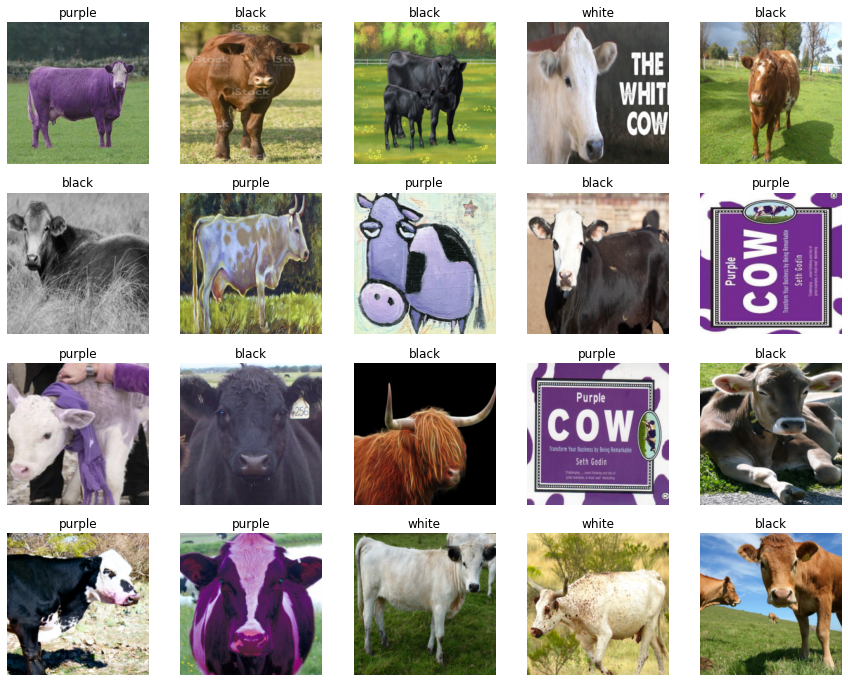

In [13]:
# show batch
dls.valid.show_batch(max_n=20)

### Create Learner and fine tune model.


In [14]:
# train
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Intrepret performance, further clean data.

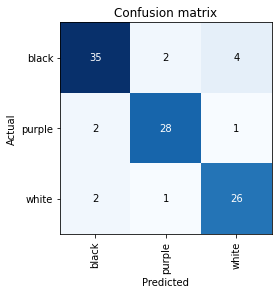

In [15]:
# interpret: confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

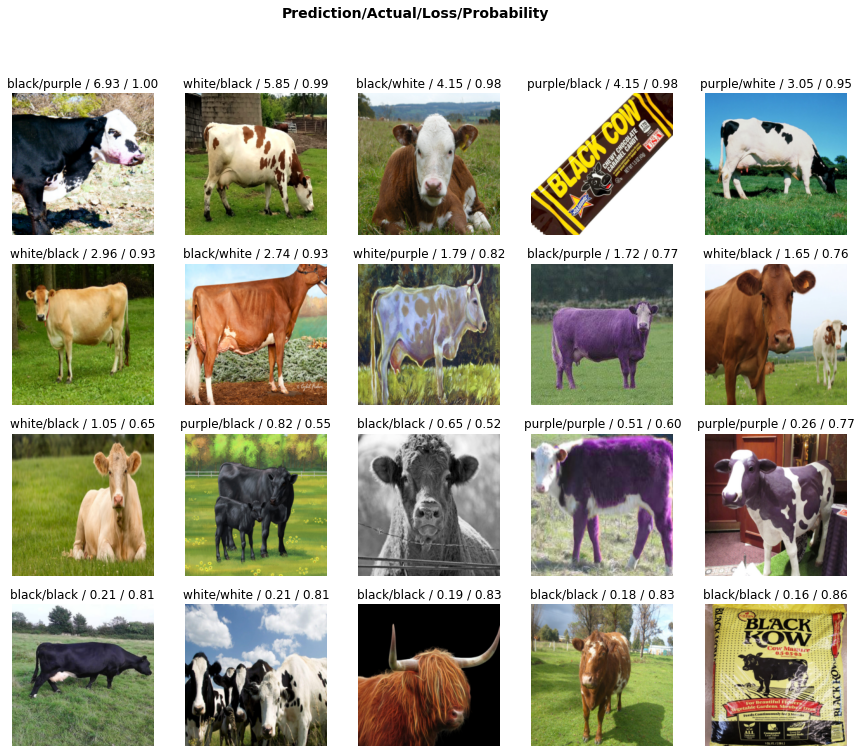

In [16]:
# interpret: plot top losses
interp.plot_top_losses(20)

In [17]:
# cleaner   - See cell 'apply cleaner' below
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
# Pause 'run after' to clean inappropriate images. Use 'run after' to resume.
#assert False

In [19]:
# apply cleaner
# The cleaner.delete() and cleaner.change() functions work based on the contents 
# of an array of values you have built inclusive of your selections above.
# For .delete() the array simply holds the index of the image selected in the 
# learners 'fns'. For .change() it holds the index and the location name to 
# "change" the file to.
# Each time you change any of the dropdowns and allow the `cleaner` to update,
# this array is re-initialized causing your selections to be lost.
# In order to make your selections execute you must run this cell prior to 
# changing any of the cleaners dropdowns or they will be lost.
# You can see this behavior by copying the contents of the uncommented four lines
# of code below into a few cells above this and work through a truth table of 
# changes to the dropdowns prior to running this cell.
#
# print('cleaner.delete():', cleaner.delete())
# for idx in cleaner.delete(): print(cleaner.fns[idx])
# print('cleaner.change():', cleaner.change())
# for idx,cat in cleaner.change(): print(cleaner.fns[idx],cat)

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Rebuild Dataloaders, create Learner, train model, intrepret performance.

In [20]:
# rebuild DataLearners
# If you have 'deleted' or 'changed' any of your image labels with the 
# ImageClassifierCleaner you should rebuild your DataLearners as files have changed.
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()).dataloaders(path)

In [21]:
# retrain
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

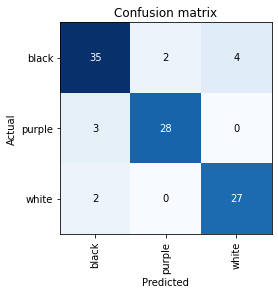

In [22]:
# reinterpret
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

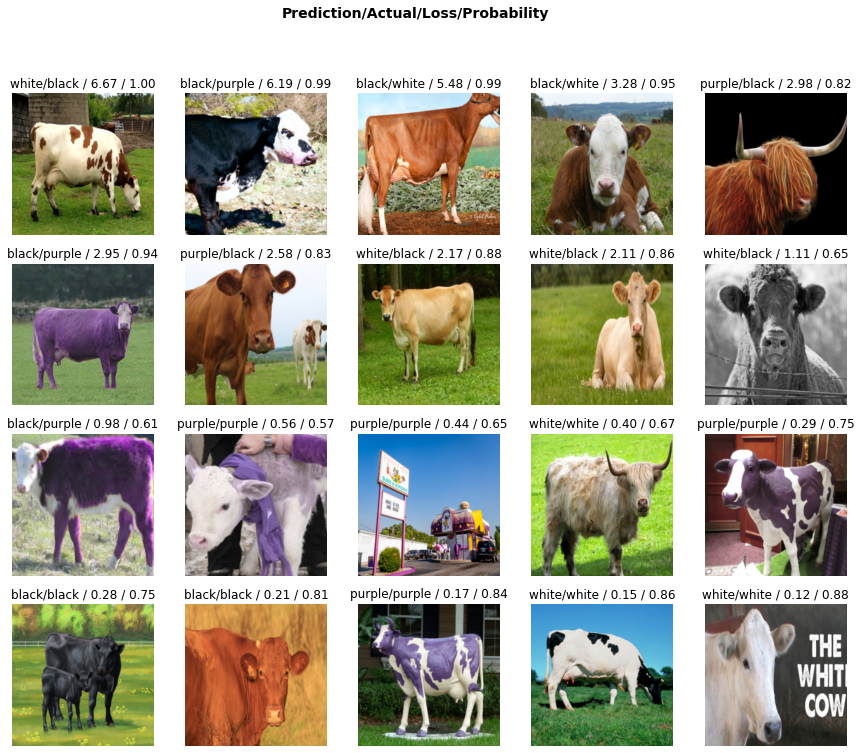

In [23]:
# reinterpret
interp.plot_top_losses(20)

In [24]:
# Break prior to export
#assert False

### Export Model.

In [25]:
# preview destination
!ls -la { model_export_path }

total 257818
drwx------ 2 root root     4096 Dec 19 18:59 'Colab Notebooks'
drwx------ 2 root root     4096 Dec 21 22:34  FastAI_PracticalDeepLearningForCoders2022
drwx------ 2 root root     4096 Dec 30 18:41  fastbook-master
-rw------- 1 root root  1560010 Jun 19  2019 'Getting started.pdf'
drwx------ 2 root root     4096 Dec 21 04:02  images
-rw------- 1 root root 87475753 Jan  7 02:12  mdlexp_boat.pkl
-rw------- 1 root root 87475575 Jan  7 21:27  mdlexp_cow.pkl
-rw------- 1 root root 87476507 Jan  6 20:19  mdlexp_trees.pkl


In [26]:
# export model
learn.export(fname=f"{model_export_path}/{model_export_name}")

In [ ]:
# verify export
!ls -la { model_export_path }

### Import model.

In [28]:
# Import model, create Learner
learn_inf = load_learner(f"{model_export_path}/{model_export_name}")

### Test on image data

cow/white/8603c632-fec5-4d18-9ade-34ecd8ccb195.JPG


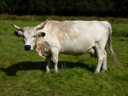

('white', TensorBase(2), TensorBase([1.7069e-06, 3.5247e-07, 1.0000e+00]))
------------------------------------------------------------
cow/white/3443011c-3b51-412b-9f4c-1fb2660d4394.jpg


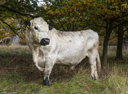

('white', TensorBase(2), TensorBase([1.2829e-06, 1.1836e-05, 9.9999e-01]))
------------------------------------------------------------
cow/white/61ed2286-7e13-43db-8d2e-71f999a8ee5c.jpg


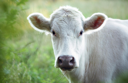

('white', TensorBase(2), TensorBase([0.0015, 0.0047, 0.9938]))
------------------------------------------------------------
cow/white/49428ef1-4734-480d-b04f-31f559e0fc23.jpg


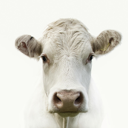

('white', TensorBase(2), TensorBase([1.1174e-06, 1.9394e-03, 9.9806e-01]))
------------------------------------------------------------
cow/white/85db436c-7f83-40a0-bbcb-c7c2947b5bb7.jpg


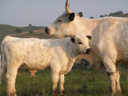

('white', TensorBase(2), TensorBase([1.7170e-04, 2.7354e-04, 9.9955e-01]))
------------------------------------------------------------
cow/black/61279f99-71d9-42b1-8e2c-edf0dae1141a.jpg


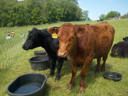

('black', TensorBase(0), TensorBase([9.9986e-01, 1.3276e-04, 9.3425e-06]))
------------------------------------------------------------
cow/black/2e311aff-194d-4060-aaf1-ed05af23f97a.jpg


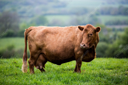

('black', TensorBase(0), TensorBase([0.9598, 0.0040, 0.0362]))
------------------------------------------------------------
cow/black/15bf8af8-26a3-437e-8d46-279f02d8cb87.jpg


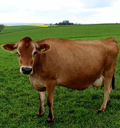

('black', TensorBase(0), TensorBase([9.9945e-01, 3.6328e-04, 1.8805e-04]))
------------------------------------------------------------
cow/black/7ab8f60d-6e83-4a48-9e5f-69bca2b23da2.jpg


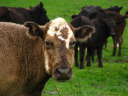

('black', TensorBase(0), TensorBase([9.9984e-01, 3.4286e-05, 1.2635e-04]))
------------------------------------------------------------
cow/black/a188e1ad-4a01-417b-bedb-cdc6b339eaf0.png


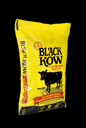

('black', TensorBase(0), TensorBase([9.9874e-01, 1.0996e-03, 1.6023e-04]))
------------------------------------------------------------
cow/purple/f482fead-6200-4e67-91c4-63e326cf2ca0.jpg


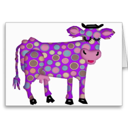

('purple', TensorBase(1), TensorBase([7.7845e-07, 1.0000e+00, 1.2616e-06]))
------------------------------------------------------------
cow/purple/13aa2a08-62af-417c-bcd3-684e261eb474.JPG


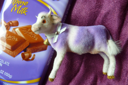

('purple', TensorBase(1), TensorBase([7.1531e-06, 9.9951e-01, 4.8189e-04]))
------------------------------------------------------------
cow/purple/9ebda296-efc4-476c-a807-77d07a047f4a.jpg


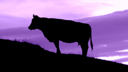

('purple', TensorBase(1), TensorBase([7.8059e-05, 9.9992e-01, 1.3905e-06]))
------------------------------------------------------------
cow/purple/168a8610-1853-494c-8694-e7985d77da54.jpg


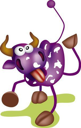

('purple', TensorBase(1), TensorBase([1.8302e-08, 1.0000e+00, 3.1402e-07]))
------------------------------------------------------------
cow/purple/56393d54-7b5b-4bb9-bdfb-15b832f8dc77.jpg


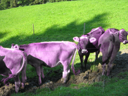

('purple', TensorBase(1), TensorBase([1.7301e-07, 1.0000e+00, 2.5284e-07]))
------------------------------------------------------------


In [29]:
# show inferences
# loop through random selecting files from already available data.
# I know that's cheating, but I'm done.
if path.exists():
  for x in classifications:
    dest = (path/x)
    #print(dest)
    if dest.exists():
      for y in range(5):
        file = dest/random.choice(os.listdir(dest))
        print(file)
        im = Image.open(file)
        display(im.to_thumb(128, 128))
        print(learn_inf.predict(file))
        print(f'-'*60)

# I think I could have done learn.predict(files[x]) for x
# then learn.show_results() but liked this.